# Continuous Control

---

In this notebook, we use **Deep Deterministic Policy Gradients ((DDPG)** to solve the **Reacher** environment.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

%reload_ext autoreload
%autoreload 2

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Linux/Reacher.x86_64',seed=1)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -7.98051071e+00 -1.00000000e+00
  5.58052063e-01  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -5.48525572e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
%%script false
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [6]:
%%script false
env.close()

### 4. Train the agents with Deep Deterministic Policy Gradients (DDPG)

The Actor and Critic agents are based on version used for the [BipedalWalker environment](https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-bipedal) from the Udacity Deep Reinforcement Learning github.
The Udacity version is modified to deal with 20 agents.

Below, we have trained several instances, with the same hyperparameters value but with different random seeds, to evaluate the consistency of the results.


In [7]:
from ddpg_agent import Agent
import torch
from collections import deque
from utils import plot_scores
import matplotlib.pyplot as plt
%matplotlib inline

device: cuda:0


In [8]:
def train_ddpg(n_episodes=2000, max_t=1000, title="Score/episode"):
    scores_deque = deque(maxlen=100)
    scores = []
    #max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        scores_agents = np.zeros(num_agents)
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores_agents += rewards                         # update the score (for each agent)
            
            agent.step(states, actions, rewards, next_states, dones)

            states = next_states                               # roll over states to next time step
            if np.any(dones):
                break 
        current_score_avg = np.mean(scores_agents)
        scores_deque.append(current_score_avg)
        scores.append(current_score_avg)
        scores_avg_100 = np.mean(scores_deque)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode,scores_avg_100, current_score_avg ), end="")
        if i_episode % 20 == 0 or scores_avg_100 >= 30:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, scores_avg_100)) 
        if scores_avg_100 >= 30 and i_episode >= 100:
            print("Environment solved in {} episodes !!!".format(i_episode-100))
            break
    plot_scores(scores, title=title)
    return scores


Episode 20	Average Score: 2.44	Score: 9.34
Episode 40	Average Score: 17.07	Score: 37.93
Episode 60	Average Score: 23.65	Score: 36.27
Episode 80	Average Score: 26.93	Score: 36.54
Episode 100	Average Score: 28.90	Score: 35.72
Episode 103	Average Score: 30.01	Score: 37.33
Environment solved in 3 episodes !!!


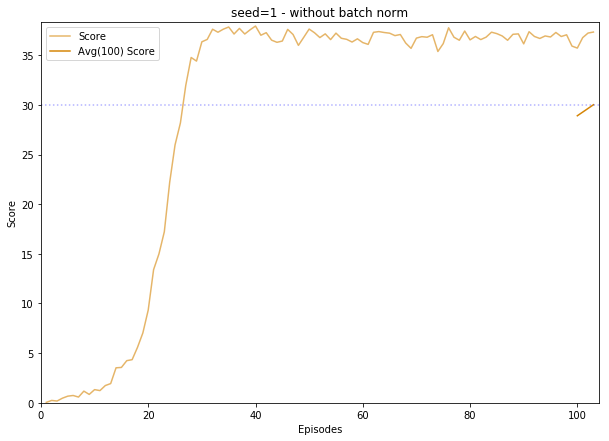

In [9]:
params={"buffer_size":int(1e5), "batch_size":128, "gamma":0.99, "tau":1e-3, "use_batch_norm":False,
       "lr_actor":1e-3, "lr_critic":5e-4, "weight_decay":0.0, "noise_theta":0.15, "noise_sigma":0.2}
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=1, **params)
scores = train_ddpg(300, title="seed=1 - without batch norm")

Episode 20	Average Score: 2.81	Score: 7.45
Episode 40	Average Score: 12.93	Score: 35.95
Episode 60	Average Score: 20.78	Score: 35.91
Episode 80	Average Score: 24.66	Score: 36.43
Episode 100	Average Score: 26.94	Score: 36.22
Episode 109	Average Score: 30.16	Score: 35.72
Environment solved in 9 episodes !!!


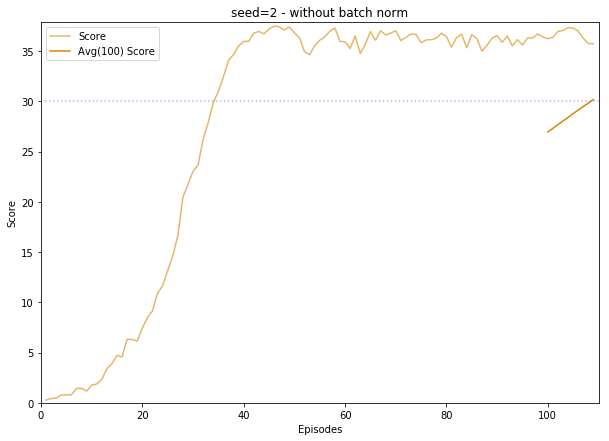

In [9]:
params={"buffer_size":int(1e5), "batch_size":128, "gamma":0.99, "tau":1e-3, "use_batch_norm":False,
       "lr_actor":1e-3, "lr_critic":5e-4, "weight_decay":0.0, "noise_theta":0.15, "noise_sigma":0.2}
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=2, **params)
scores = train_ddpg(300, title="seed=2 - without batch norm")

Episode 20	Average Score: 1.72	Score: 5.15
Episode 40	Average Score: 14.58	Score: 37.13
Episode 60	Average Score: 21.84	Score: 36.41
Episode 80	Average Score: 25.60	Score: 36.30
Episode 100	Average Score: 27.88	Score: 36.48
Episode 106	Average Score: 30.10	Score: 37.31
Environment solved in 6 episodes !!!


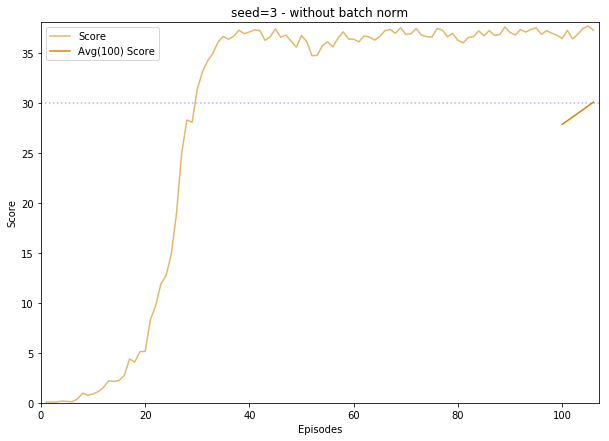

In [9]:
params={"buffer_size":int(1e5), "batch_size":128, "gamma":0.99, "tau":1e-3, "use_batch_norm":False,
       "lr_actor":1e-3, "lr_critic":5e-4, "weight_decay":0.0, "noise_theta":0.15, "noise_sigma":0.2}
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=3, **params)
scores = train_ddpg(300, title="seed=3 - without batch norm")

Episode 20	Average Score: 4.71	Score: 12.56
Episode 40	Average Score: 16.85	Score: 36.99
Episode 60	Average Score: 23.59	Score: 37.54
Episode 80	Average Score: 27.10	Score: 37.86
Episode 100	Average Score: 29.19	Score: 36.64
Episode 103	Average Score: 30.27	Score: 36.59
Environment solved in 3 episodes !!!


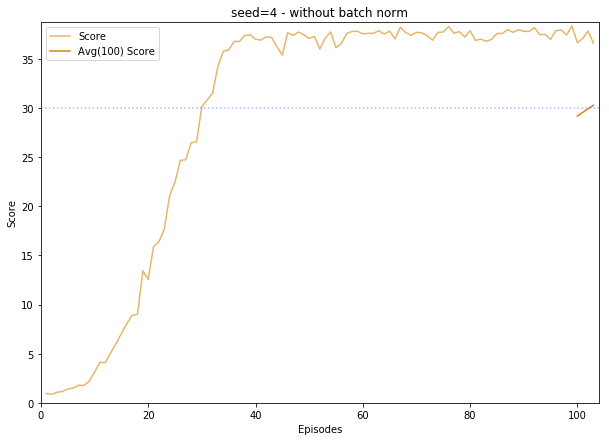

In [9]:
params={"buffer_size":int(1e5), "batch_size":128, "gamma":0.99, "tau":1e-3, "use_batch_norm":False,
       "lr_actor":1e-3, "lr_critic":5e-4, "weight_decay":0.0, "noise_theta":0.15, "noise_sigma":0.2}
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=4, **params)
scores = train_ddpg(300, title="seed=4 - without batch norm")

### 5. Watch a Smart Agent!
In the next code cell, we load the trained weights from file to watch a smart agent!

In [8]:

agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=2)

agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
for t in range(200):
    actions = agent.act(states, add_noise=False)
    env_info = env.step(actions)[brain_name]  
    states = env_info.vector_observations
    dones = env_info.local_done                        # see if episode finished
      
    if np.any(dones):
        break 



In [ ]:
env.close()